# Acoustic SoftDTW-FWI parametrized in velocity using only refractions

This notebook performs acoustic FWI parametrized in velocity using only refracted arrivals. It is mostly aimed at showcasing the SoftDTW objective function in ``devitofwi.loss.dtw.SoftDTW`` implemented in the tslearn library with PyTorch.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from devito import configuration
from itertools import chain
from pylops.basicoperators import Diagonal#, Identity

from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.preproc.masking import TimeSpaceMasking
from devitofwi.loss.dtw import SoftDTW
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP
from devitofwi.fwi.acoustic import AcousticFWI2D

configuration['log-level'] = 'ERROR'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

/home/ravasim/Documents/2024/Projects/Devito-fwi/devitofwi/waveengine/acoustic.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using device cuda


/home/ravasim/miniconda3_v23/envs/devitofwi_gpu/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':7,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Time-space mask parameters
vwater = 1.5
toff = 0.35

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

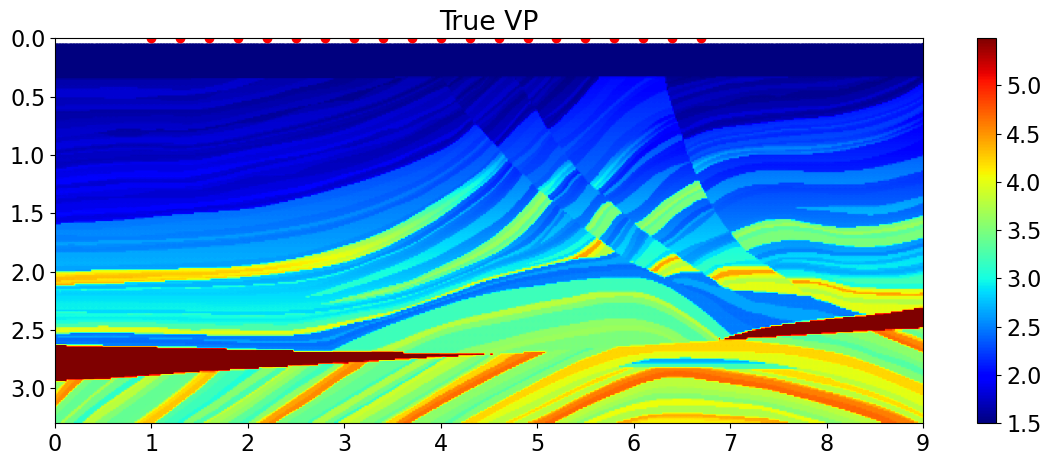

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(221, 601).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

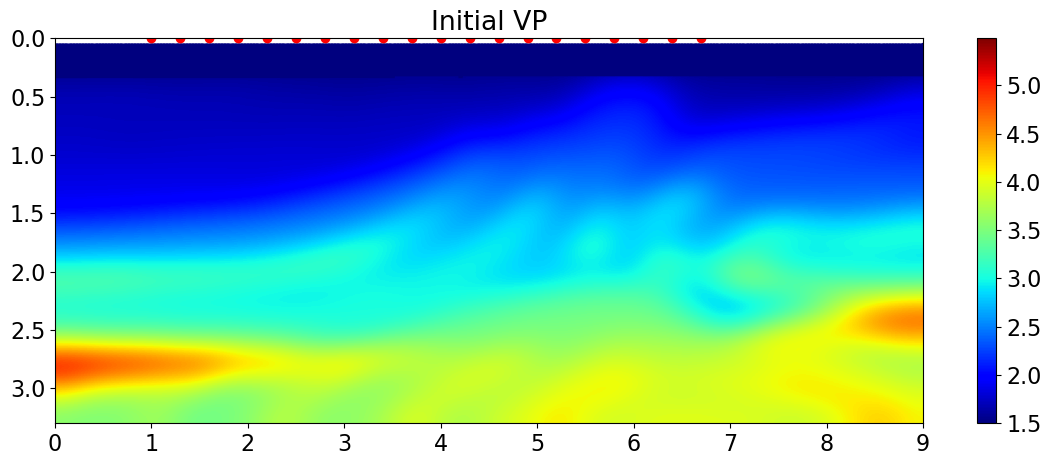

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
# msk = msk[250:450, :100]
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl)

# Create model and geometry to extract useful information to define the filtering object
model, geometry = amod.model_and_geometry()

In [9]:
# Model data
dobs, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

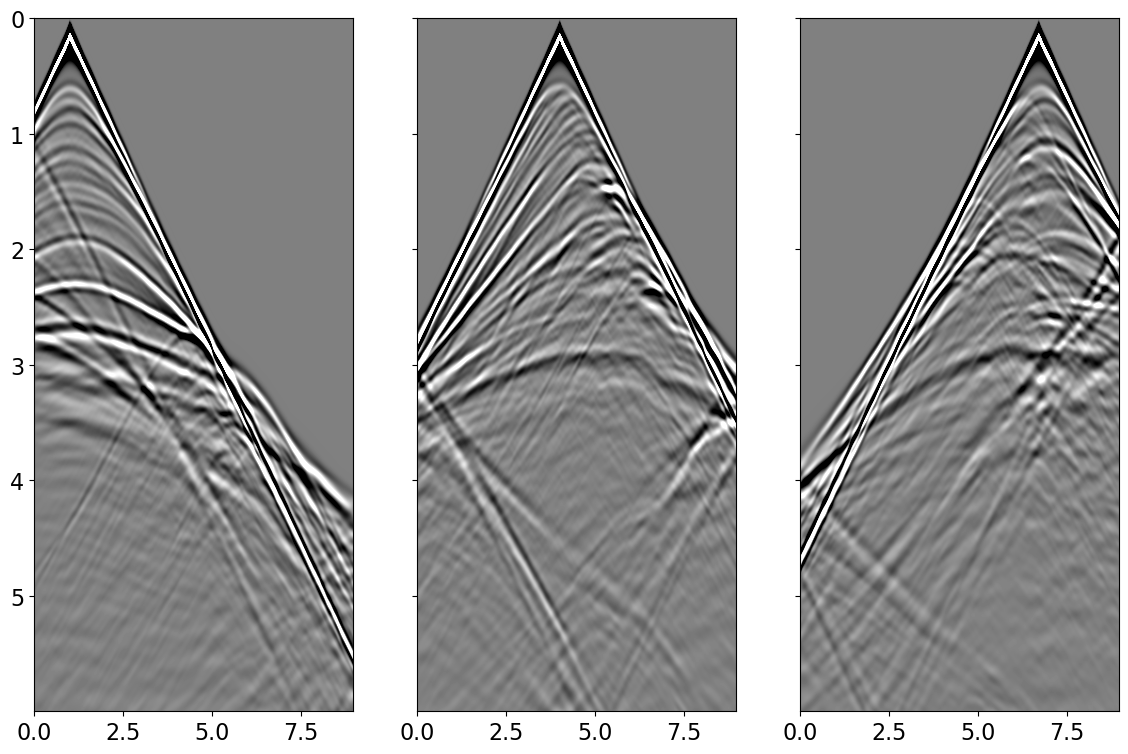

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)

## Mask creation

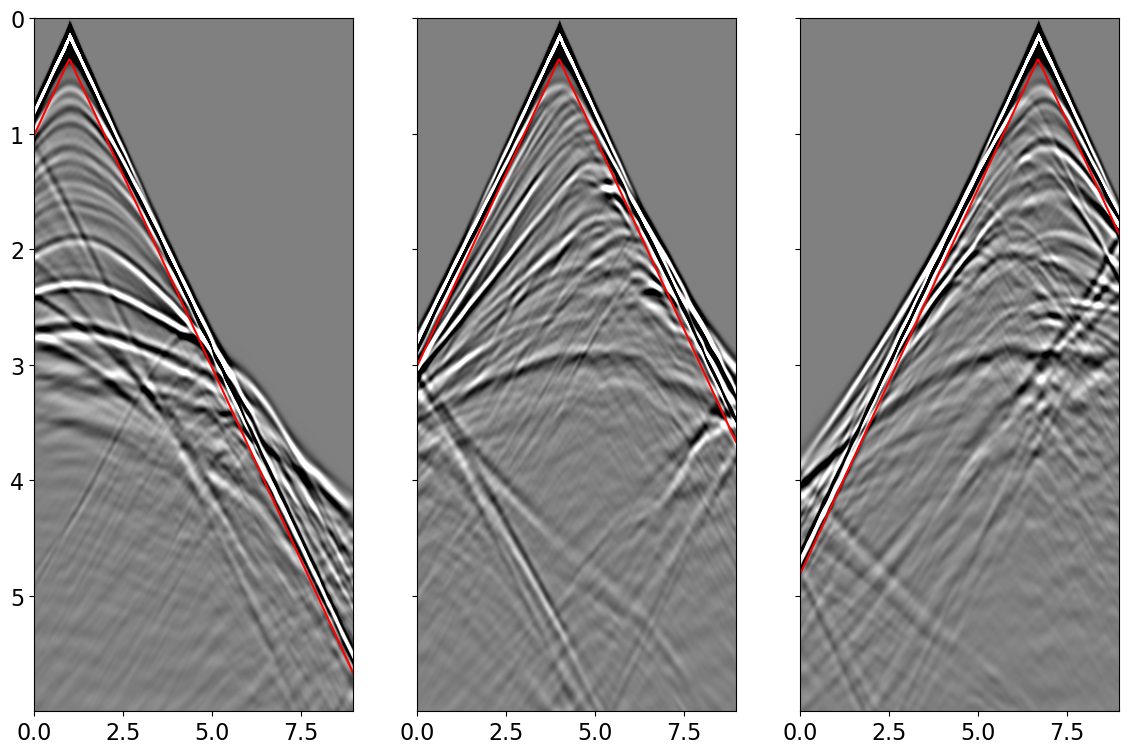

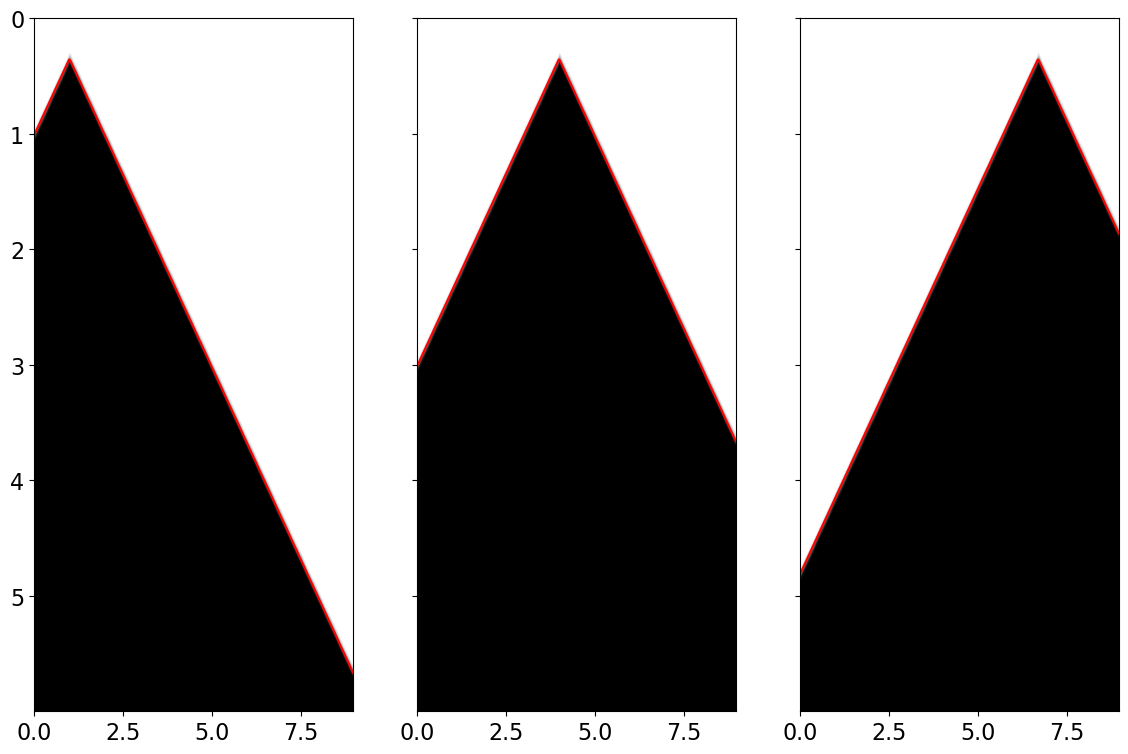

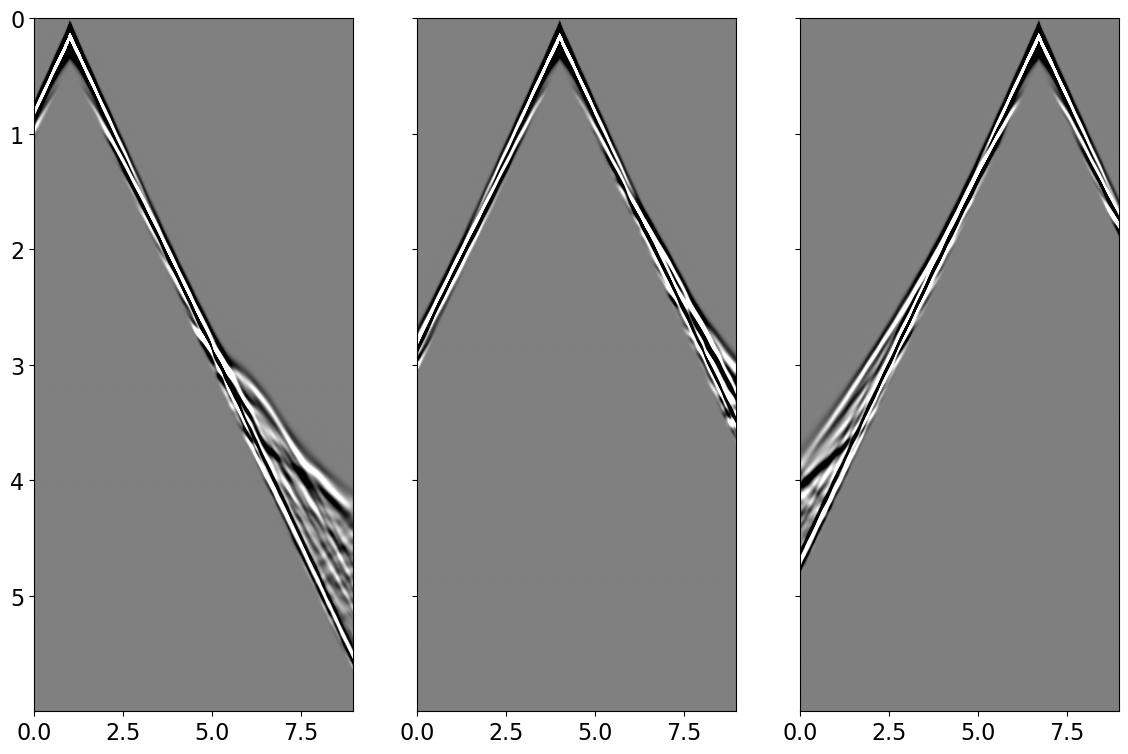

In [11]:
# Create direct arrival mask
distance = np.sqrt((x_s[:, 0][:, None]-x_r[:, 0][None, :])**2 + (x_s[:, 1][:, None]-x_r[:, 1][None, :])**2)
directtime = distance / vwater
tsmask = TimeSpaceMasking(directtime, geometry.nt, geometry.dt, toff, nsmooth=50)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=0, vmax=1)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot] * tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax);

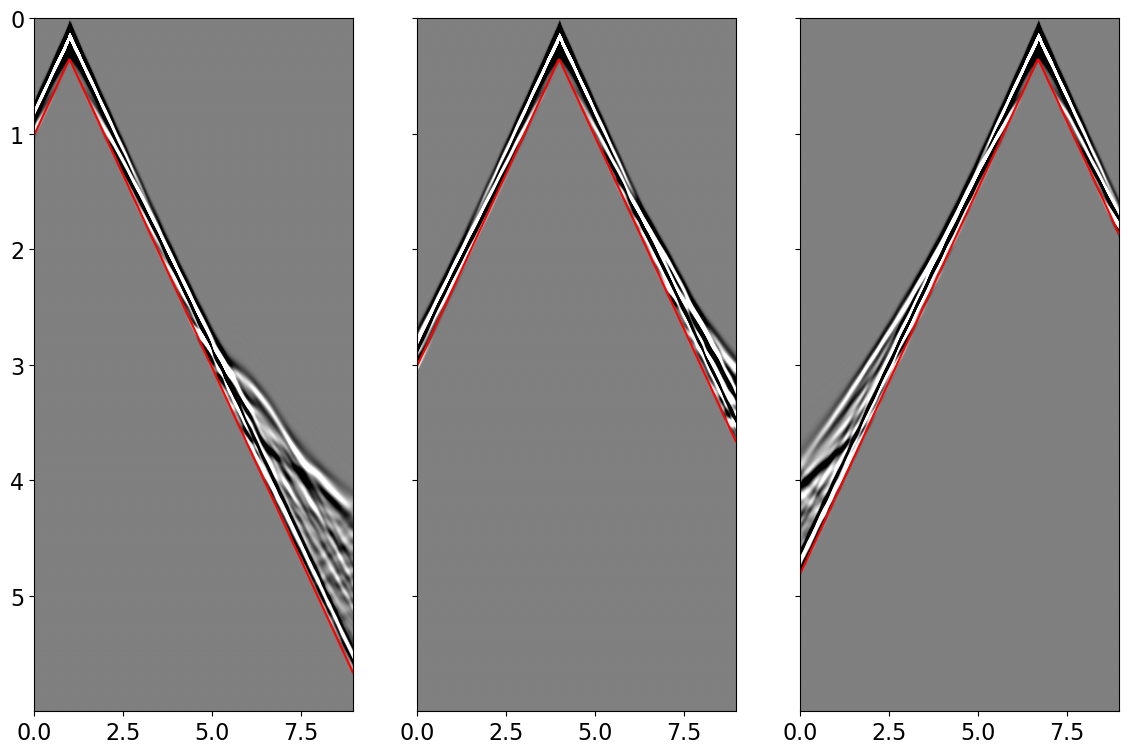

In [12]:
# Mask observed data to have direct arrival and refractions
TSmaskop = [Diagonal(tsmask.mask[isrc].T.ravel()) for isrc in range(par['ns'])]
dobs_masked = np.hstack([(TSmaskop[isrc] @ dobs[isrc].ravel())[None, :] for isrc in range(par['ns'])])
dobs_masked = dobs_masked.reshape(par['ns'], geometry.nt, par['nr'])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')

## Inversion with L-BFGS

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76142D+02    |proj g|=  1.05559D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  3.77652D+02    |proj g|=  9.16937D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  1.96260D+02    |proj g|=  5.20204D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  1.38648D+02    |proj g|=  3.72710D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  8.77923D+01    |proj g|=  3.93209D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  7.08157D+01    |proj g|=  2.30712D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  6.30653D+01    |proj g|=  9.45804D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  5.74051D+01    |proj g|=  7.44498D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  4.86587D+01    |proj g|=  1.29017D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  4.25547D+01    |proj g|=  9.38102D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  3.72681D+01    |proj g|=  8.67208D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  3.31890D+01    |proj g|=  3.99556D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  3.00225D+01    |proj g|=  4.60474D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  2.76614D+01    |proj g|=  8.98173D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  2.55457D+01    |proj g|=  7.94905D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  2.31653D+01    |proj g|=  5.65615D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  2.18430D+01    |proj g|=  7.10238D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  2.05395D+01    |proj g|=  4.28196D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  1.92137D+01    |proj g|=  2.95533D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  1.82256D+01    |proj g|=  3.57025D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  1.70410D+01    |proj g|=  5.19387D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  1.64505D+01    |proj g|=  3.34178D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  1.57545D+01    |proj g|=  2.52080D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  1.47832D+01    |proj g|=  3.47033D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  1.41570D+01    |proj g|=  5.65265D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  1.34045D+01    |proj g|=  3.29148D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  1.26546D+01    |proj g|=  2.81137D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  1.22554D+01    |proj g|=  2.55254D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  1.14753D+01    |proj g|=  5.31677D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  1.09921D+01    |proj g|=  2.94960D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  1.07298D+01    |proj g|=  1.64832D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  1.04105D+01    |proj g|=  1.27706D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  1.00535D+01    |proj g|=  1.54245D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  9.79536D+00    |proj g|=  4.21596D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  9.43165D+00    |proj g|=  2.37620D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  9.13834D+00    |proj g|=  1.06057D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  8.90781D+00    |proj g|=  1.65054D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  8.64684D+00    |proj g|=  2.34851D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  8.38714D+00    |proj g|=  1.65533D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  8.12808D+00    |proj g|=  1.39963D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  7.80591D+00    |proj g|=  3.27116D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  7.68478D+00    |proj g|=  1.18540D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  7.52179D+00    |proj g|=  1.19998D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  7.25955D+00    |proj g|=  1.28409D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  6.95546D+00    |proj g|=  9.04690D-03


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  6.72208D+00    |proj g|=  2.79190D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  6.50963D+00    |proj g|=  1.68446D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  6.36693D+00    |proj g|=  1.71172D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  6.19190D+00    |proj g|=  1.31396D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  5.98452D+00    |proj g|=  1.79095D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  5.85863D+00    |proj g|=  1.75937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     52      1     0     0   1.759D-02   5.859D+00
  F =   5.8586320239245575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


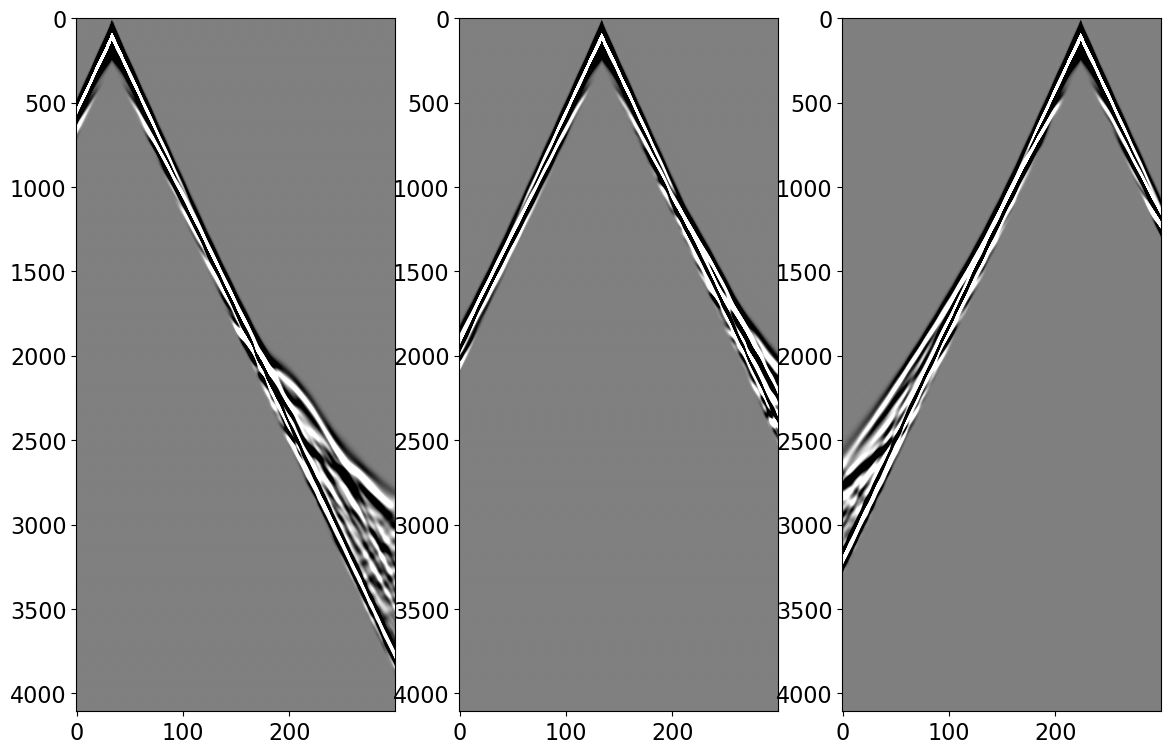

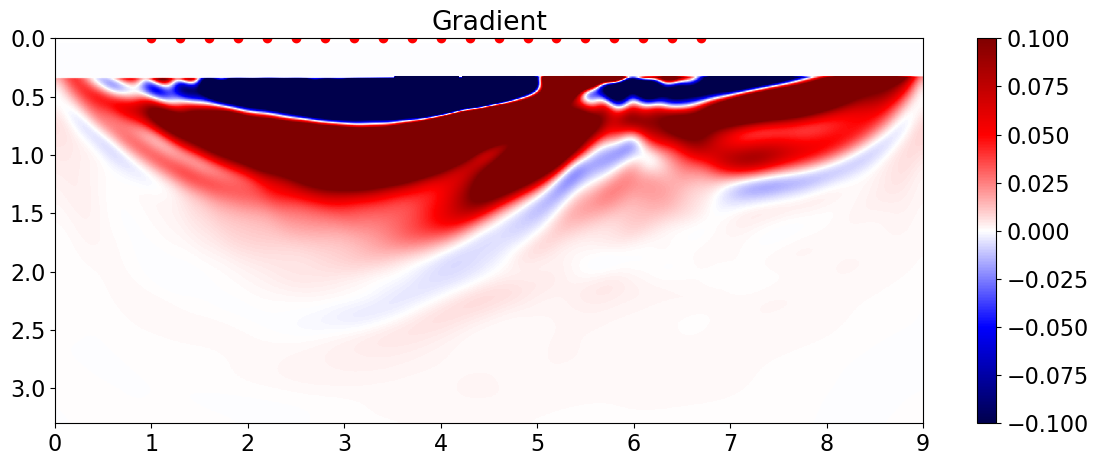

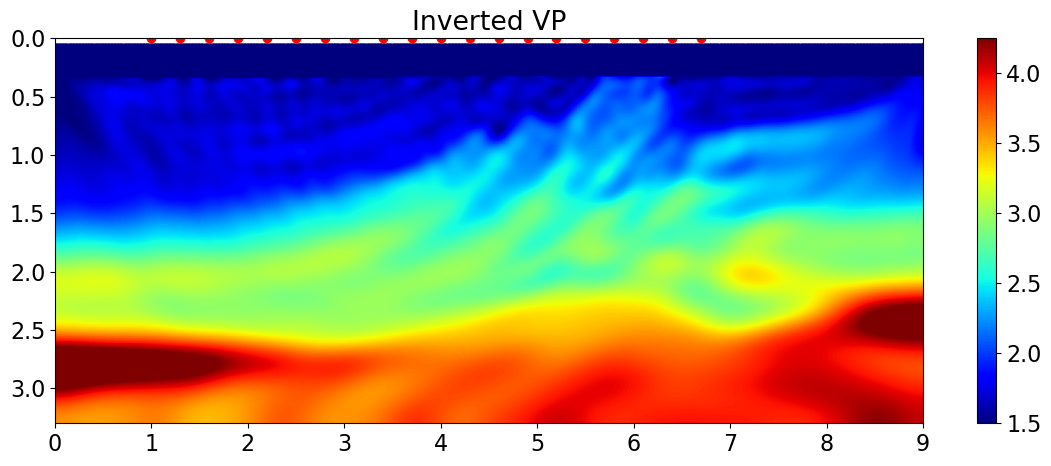

In [13]:
# Note that since the data has very small amplitudes, a constant scaling is applied to both the data and wavelet using for modelling;
# this avoids issues with the loss becoming very small; moreover, when the parameter normalize=True, the SoftDTW divergence is used.
# Also, the loss is computed on a time-subsampled version of the data (t_sub=5) to manage memory.
dscaling = 1e6 
normalize = True
t_sub = 5 # subsampling for SoftDTW
gamma = 1e3 # regularization parameter for SoftDTW
wav = geometry.src.wavelet
postprocess = PostProcessVP(scaling=1, mask=msk, sigmas=(4, 4))
vp_error_hist = []

afwi = AcousticFWI2D(par, vp_init=vp_init, vp_range=(vp_true.min(), vp_true.max()),
                     wav=dscaling * wav, loss=SoftDTW, lossop=TSmaskop,
                     space_order=space_order, nbl=nbl, 
                     firstscaling=True, postprocess=postprocess, solver='L-BFGS-B',
                     kwargs_loss={'nr':par['nr'], 'nt':geometry.nt, 'gamma':gamma, 
                                  'normalize':True, 't_sub':t_sub, 'device':device},
                     kwargs_solver={'ftol':0, 'gtol':0, 'maxiter':50, 'maxfun':200, 'disp':True},
                     callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error_hist))

vp_inv, loss_hist, nl = afwi.run(dscaling * dobs_masked, plotflag=True)

In [14]:
nl

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 5.8586320239245575
        x: [ 1.500e+00  1.500e+00 ...  4.088e+00  4.089e+00]
      nit: 50
      jac: [-0.000e+00 -0.000e+00 ...  2.005e-06  2.068e-06]
     nfev: 52
     njev: 52
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>

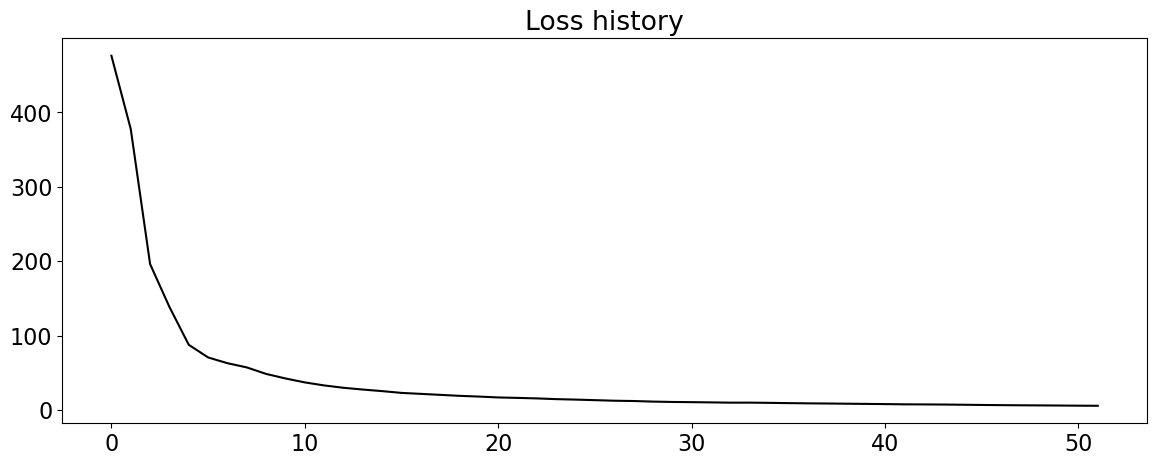

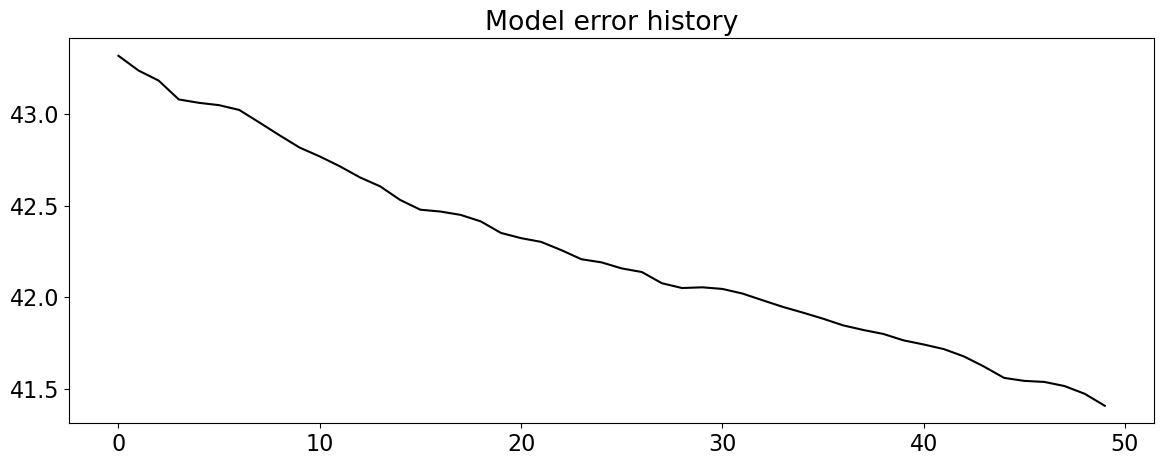

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(list(chain.from_iterable(loss_hist)), 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error_hist, 'k')
plt.title('Model error history');

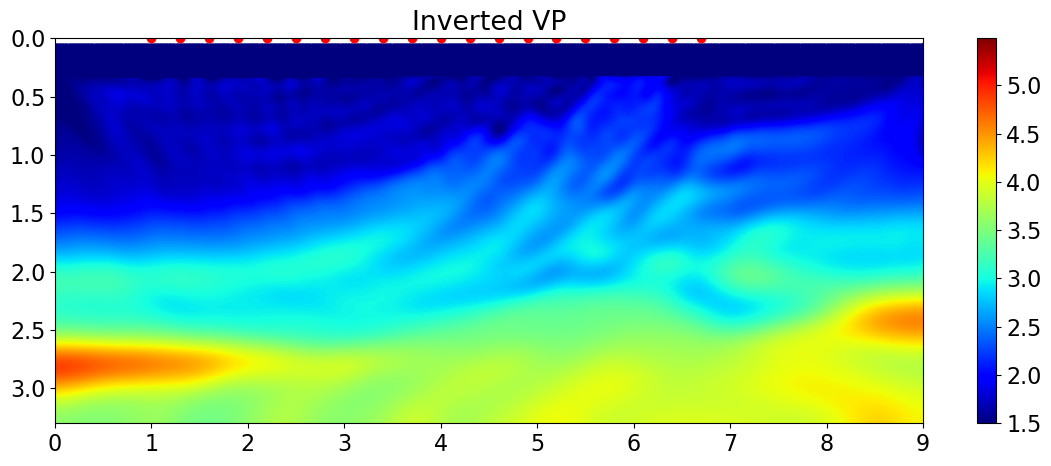

In [16]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

In [17]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

dinv = ainvfinal.mod_allshots(dt=geometry.dt)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
# Mask predicted data
dinv_masked = np.hstack([(TSmaskop[isrc] @ dinv[isrc, :dobs.shape[1]].ravel())[None, :] for isrc in range(par['ns'])])
dinv_masked = dinv_masked.reshape(par['ns'], geometry.nt, par['nr'])

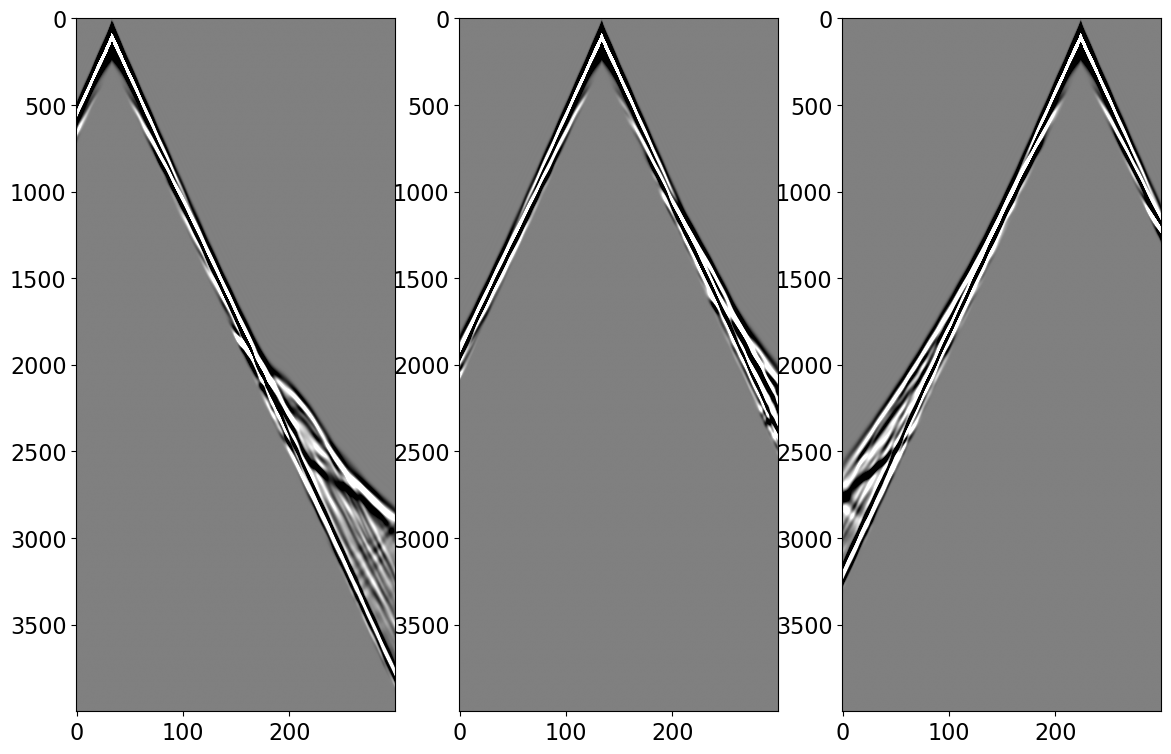

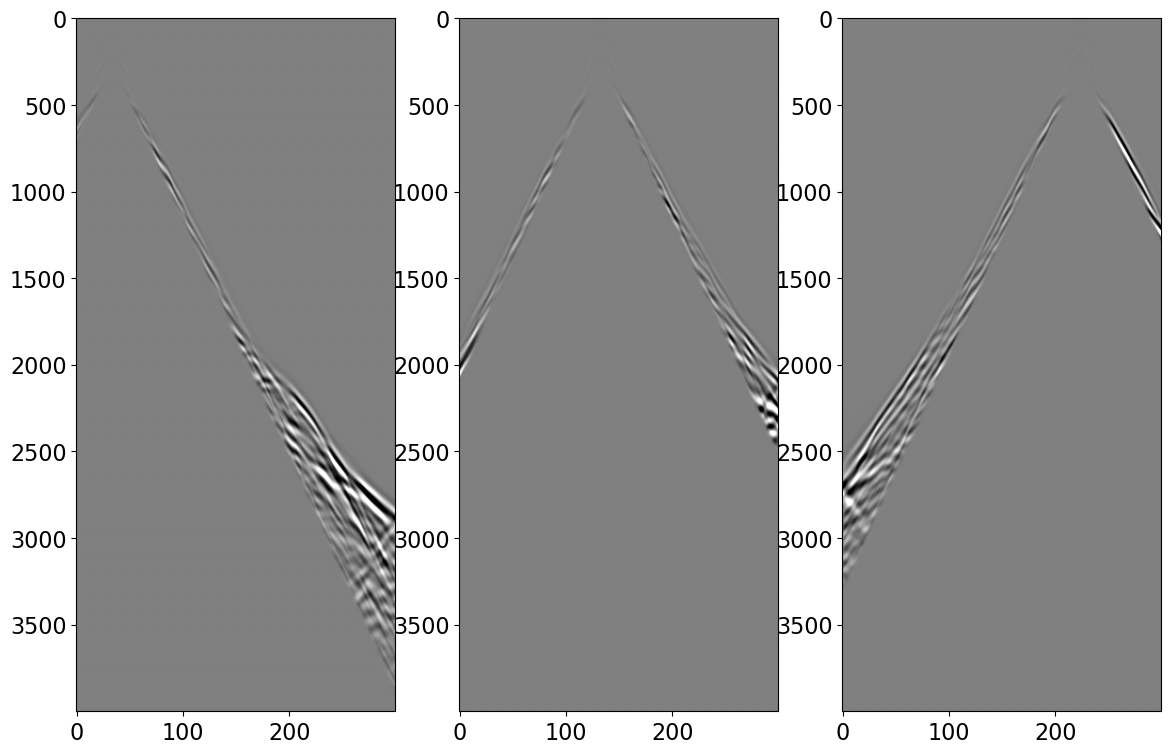

In [19]:
# Display modelling error
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot, :ntmax] - dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)